# Laboratorio 4 — Modelos con Datos Geoespaciales

**Fecha:** 2025-08-14
**Integrantes:** Emilio Reyes, Silvia Illescas, Michelle Mejia

Este notebook sigue paso a paso las instrucciones del laboratorio para analizar cianobacteria en los lagos **Atitlán** y **Amatitlán** usando **Sentinel‑2**.


## Contenido
1. Preparación del entorno
2. Conexión a openEO (CDSE)
3. Definición de AOIs y rango temporal (≥ 6 meses)
4. Descarga/Exportación de índices (NDCI, NDVI, NDWI) como GeoTIFF
5. Conversión a NumPy y series de tiempo por lago
6. Mapas espaciales y comparación entre fechas
7. Correlación NDCI ↔ NDVI/NDWI
8. Modelos: serie temporal, clasificación y modelo híbrido
9. Visualización de proyecciones en mapa

**Nota:** El código de descarga vía openEO se ejecuta conectado a internet y con autenticación.


## 1) Preparación del entorno

In [1]:

!pip install openeo rasterio rioxarray xarray numpy pandas matplotlib folium shapely geopandas pyproj statsmodels scikit-learn

import os, glob, math, json
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reglas para gráficos
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True
print('Entorno listo.')

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 6.5 MB/s  0:00:00
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   -- ------------------------------------- 1.8/25.4 MB 9.1 MB/s eta 0:00:03
   ----- ---------------------------------- 3.4/25.4 MB 9.1 MB/s eta 0:00:03
   ------- -------------------------------- 5.0/25.4 MB 8.1 MB/s eta 0:00:03
   ---------- ----------------------------- 6.6/25.4 MB 8.0 MB/s eta 0:00:03
   ------------- -------------------------- 8.7/25.4 MB 8.4 MB/s eta 0:00:03
   ---------------- ----------------------- 10.7/25.4 MB 8.8 MB/s eta 0:00:02
   -------------------- ------------------- 12.8/25.4 MB 8.8 MB/s eta 0:00:02
   ----------------------- ---------------- 14.7/25.4 MB 8.9 MB/s eta 0:00:02
   --------------------------- ------------ 17.3/25.4 MB 9.2 MB/s eta 0:00:01
   ------------------------------ --------- 19.7/25.4 MB 9.3 MB/s eta 0:00:01
   ----------

## 2) Conexión a openEO (CDSE)
Se conecta al backend de *Copernicus Data Space Ecosystem*. Puedes autenticar con navegador (OIDC) o con credenciales de cliente.
**Ejecuta esta celda solo cuando estés listo para descargar/ procesar datos.**

In [7]:
# Conexión a openEO (ejecuta cuando tengas internet y credenciales)
try:
    import openeo
    con = openeo.connect("https://openeo.dataspace.copernicus.eu")
    # Opción A: autenticación interactiva (abre navegador)
    con = con.authenticate_oidc()
    #
    # Opción B: client credentials (si ya registraste un OAuth client)
    # con = con.authenticate_oidc_client_credentials(client_id="TU_CLIENT_ID", client_secret="TU_CLIENT_SECRET")
    print("Conexión inicializada. Autentica con uno de los métodos comentados.")
except Exception as e:
    print("openeo no disponible en este entorno o falta internet/credenciales:", e)

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=EMRE-ZHFC 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
Conexión inicializada. Autentica con uno de los métodos comentados.


## 3) AOIs y rango temporal (≥ 6 meses)
Usamos los *bounding boxes* provistos en el enunciado. Ajusta las fechas si lo deseas.

In [8]:
# Bounding boxes del laboratorio
atitlan_bbox = {"west": -91.326256, "east": -91.07151, "south": 14.5948, "north": 14.750979}
amatitlan_bbox = {"west": -90.638065, "east": -90.512924, "south": 14.412347, "north": 14.493799}

# Ventana temporal >= 6 meses
start_date = "2025-01-01"
end_date   = "2025-07-31"
collection = "SENTINEL2_L2A"  # Surface Reflectance recomendado
print("AOIs y fechas definidos.")

AOIs y fechas definidos.


## 4) Exportar índices (NDCI, NDVI, NDWI) con openEO a GeoTIFF
Creamos un cubo, filtramos nubosidad y enmascaramos usando SCL. Luego calculamos índices y guardamos como GeoTIFF.
**Nota:** Esta sección requiere conexión real a openEO/CDSE.

Esto solo aplica para atitlan, ya que amatitlan son otras fechas las que no tienen nubosidad....

In [9]:
# === Paso 4 (definitivo): un job por fecha, con retry y cálculo local de índices ===
import os, time, glob, datetime as dt
import numpy as np
import rasterio

# Fechas suministradas (deduplicadas y ordenadas)
fechas_filtradas = sorted(set([
    "2025-02-07","2025-02-10","2025-02-25","2025-02-27",
    "2025-03-02","2025-03-04","2025-03-07","2025-03-09",
    "2025-03-12","2025-03-14","2025-03-19","2025-03-22",
    "2025-03-24","2025-03-26","2025-04-03","2025-04-11",
    "2025-04-13","2025-04-15","2025-04-16","2025-04-18",
    "2025-04-28","2025-05-03","2025-05-13","2025-05-28",
    "2025-07-10","2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]))

def _next_day(d):  # 'YYYY-MM-DD' -> 'YYYY-MM-DD' + 1
    return (dt.datetime.fromisoformat(d) + dt.timedelta(days=1)).date().isoformat()

def _write_singleband_tif(ref_src, array, out_path, nodata=np.nan):
    profile = ref_src.profile.copy()
    profile.update(count=1, dtype="float32", nodata=nodata)
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(array.astype("float32"), 1)

def _calc_indices_and_save(src_path, out_base, date_str):
    with rasterio.open(src_path) as src:
        if src.count < 5:
            print(f"Saltando {src_path}: se esperaban 5 bandas (B03,B04,B05,B08,SCL).")
            return
        B03 = src.read(1).astype("float32")
        B04 = src.read(2).astype("float32")
        B05 = src.read(3).astype("float32")
        B08 = src.read(4).astype("float32")
        SCL = src.read(5)

        # Máscara: agua y sin nubes/sombras
        is_water = (SCL == 6)
        is_cloud = ((SCL == 3) | (SCL == 8) | (SCL == 9) | (SCL == 10) | (SCL == 11))
        mask = is_water & (~is_cloud)

        # Escala a reflectancia
        scale = 0.0001
        B03s, B04s, B05s, B08s = B03*scale, B04*scale, B05*scale, B08*scale
        eps = 1e-6

        ndci = (B05s - B04s) / (B05s + B04s + eps)
        ndvi = (B08s - B04s) / (B08s + B04s + eps)
        ndwi = (B03s - B08s) / (B03s + B08s + eps)

        ndci[~mask] = np.nan
        ndvi[~mask] = np.nan
        ndwi[~mask] = np.nan

        for name, arr in [("ndci", ndci), ("ndvi", ndvi), ("ndwi", ndwi)]:
            out_dir = os.path.join(out_base, name)
            os.makedirs(out_dir, exist_ok=True)
            _write_singleband_tif(src, arr, os.path.join(out_dir, f"{name}_{date_str}.tif"))

def _download_one_day(con, bbox, collection_id, date_str, raw_dir, job_title, max_retries=4):
    start, end = date_str, _next_day(date_str)
    cube = con.load_collection(
        collection_id,
        spatial_extent=bbox,
        temporal_extent=[start, end],
        bands=["B03","B04","B05","B08","SCL"],
    )
    job = cube.save_result(format="GTIFF")
    backoff = 2.0
    for attempt in range(1, max_retries+1):
        try:
            batch = con.create_job(job, title=f"{job_title}_{date_str}")
            res = batch.start_and_wait()
            os.makedirs(raw_dir, exist_ok=True)
            res.download_results(raw_dir)
            print(f"✅ Descargado {job_title} {date_str}")
            return True
        except Exception as e:
            msg = str(e)
            if "Too Many Requests" in msg or "429" in msg:
                print(f"⚠️ 429 en {date_str}. Reintentando en {backoff:.1f}s (intento {attempt}/{max_retries})...")
                time.sleep(backoff)
                backoff *= 1.8
            else:
                print(f"❌ Falló {date_str}: {e}")
                return False
    print(f"❌ Agotados reintentos para {date_str}")
    return False

def pipeline_per_area(con, bbox, area_name, out_base, fechas):
    raw_dir = os.path.join(out_base, "raw")
    os.makedirs(raw_dir, exist_ok=True)
    ok = 0
    for d in fechas:
        if _download_one_day(con, bbox, collection, d, raw_dir, f"{area_name}_RAW"):
            # hallar el tif recién bajado (multibanda)
            tifs = sorted(glob.glob(os.path.join(raw_dir, "**", "*.tif"), recursive=True), key=os.path.getmtime)
            if not tifs:
                print(f"⚠️ No se encontró el GeoTIFF para {d}")
                continue
            latest = tifs[-1]
            _calc_indices_and_save(latest, out_base, d)
            ok += 1
    print(f"✔️ {area_name}: {ok}/{len(fechas)} fechas procesadas")

# Ejecuta por lago (uno a la vez, para evitar 429)
pipeline_per_area(con, atitlan_bbox,   "Atitlan",   "out_atitlan",   fechas_filtradas)
# Cuando termine Atitlán, ejecuta Amatitlán:
#pipeline_per_area(con, amatitlan_bbox, "Amatitlan", "out_amatitlan", fechas_filtradas)


0:00:00 Job 'j-25081503154846558d8716a6efa2a7bd': send 'start'
0:00:15 Job 'j-25081503154846558d8716a6efa2a7bd': created (progress 0%)
0:00:20 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:27 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:35 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:45 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:00:57 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:01:13 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:01:33 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:01:57 Job 'j-25081503154846558d8716a6efa2a7bd': running (progress N/A)
0:02:27 Job 'j-25081503154846558d8716a6efa2a7bd': finished (progress 100%)


C:\Users\Silvia\AppData\Local\Temp\ipykernel_13420\217361891.py:75: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  res.download_results(raw_dir)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


✅ Descargado Atitlan_RAW 2025-02-07
0:00:00 Job 'j-25081503194347acb4811ac55bc819ab': send 'start'
0:00:13 Job 'j-25081503194347acb4811ac55bc819ab': created (progress 0%)
0:00:18 Job 'j-25081503194347acb4811ac55bc819ab': created (progress 0%)
0:00:25 Job 'j-25081503194347acb4811ac55bc819ab': created (progress 0%)
0:00:33 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:00:43 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:00:55 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:01:11 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:01:30 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:01:55 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:02:25 Job 'j-25081503194347acb4811ac55bc819ab': running (progress N/A)
0:03:02 Job 'j-25081503194347acb4811ac55bc819ab': finished (progress 100%)
✅ Descargado Atitlan_RAW 2025-02-10
0:00:00 Job 'j-25081503242742a4a7c264305a9effc6': send 'start'


In [11]:
# === Paso 4 (Amatitlán solamente): un job por fecha, con retry y cálculo local de índices ===
import os, time, glob, datetime as dt
import numpy as np
import rasterio

# Fechas para AMATITLÁN (2025) según tu lista
fechas_amatitlan = sorted(set([
    # Febrero
    "2025-02-07", "2025-02-12", "2025-02-22", "2025-02-27",
    # Marzo
    "2025-03-04", "2025-03-09", "2025-03-14", "2025-03-19", "2025-03-24", "2025-03-26",
    # Abril
    "2025-04-03", "2025-04-13", "2025-04-15", "2025-04-18", "2025-04-28",
    # Mayo
    "2025-05-13",
    # Junio
    "2025-06-14",
    # Julio
    "2025-07-17", "2025-07-22", "2025-07-24", "2025-07-27",
]))

def _next_day(d):  # 'YYYY-MM-DD' -> 'YYYY-MM-DD' + 1
    return (dt.datetime.fromisoformat(d) + dt.timedelta(days=1)).date().isoformat()

def _write_singleband_tif(ref_src, array, out_path, nodata=np.nan):
    profile = ref_src.profile.copy()
    profile.update(count=1, dtype="float32", nodata=nodata)
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(array.astype("float32"), 1)

def _calc_indices_and_save(src_path, out_base, date_str):
    with rasterio.open(src_path) as src:
        if src.count < 5:
            print(f"Saltando {src_path}: se esperaban 5 bandas (B03,B04,B05,B08,SCL).")
            return
        B03 = src.read(1).astype("float32")
        B04 = src.read(2).astype("float32")
        B05 = src.read(3).astype("float32")
        B08 = src.read(4).astype("float32")
        SCL = src.read(5)

        # Máscara: agua y sin nubes/sombras
        is_water = (SCL == 6)
        is_cloud = ((SCL == 3) | (SCL == 8) | (SCL == 9) | (SCL == 10) | (SCL == 11))
        mask = is_water & (~is_cloud)

        # Escala a reflectancia
        scale = 0.0001
        B03s, B04s, B05s, B08s = B03*scale, B04*scale, B05*scale, B08*scale
        eps = 1e-6

        ndci = (B05s - B04s) / (B05s + B04s + eps)
        ndvi = (B08s - B04s) / (B08s + B04s + eps)
        ndwi = (B03s - B08s) / (B03s + B08s + eps)

        ndci[~mask] = np.nan
        ndvi[~mask] = np.nan
        ndwi[~mask] = np.nan

        for name, arr in [("ndci", ndci), ("ndvi", ndvi), ("ndwi", ndwi)]:
            out_dir = os.path.join(out_base, name)
            os.makedirs(out_dir, exist_ok=True)
            _write_singleband_tif(src, arr, os.path.join(out_dir, f"{name}_{date_str}.tif"))

def _download_one_day(con, bbox, collection_id, date_str, raw_dir, job_title, max_retries=4):
    start, end = date_str, _next_day(date_str)
    cube = con.load_collection(
        collection_id,
        spatial_extent=bbox,
        temporal_extent=[start, end],
        bands=["B03","B04","B05","B08","SCL"],
    )
    job = cube.save_result(format="GTIFF")
    backoff = 2.0
    for attempt in range(1, max_retries+1):
        try:
            batch = con.create_job(job, title=f"{job_title}_{date_str}")
            res = batch.start_and_wait()
            os.makedirs(raw_dir, exist_ok=True)
            res.download_results(raw_dir)
            print(f"✅ Descargado {job_title} {date_str}")
            return True
        except Exception as e:
            msg = str(e)
            if "Too Many Requests" in msg or "429" in msg:
                print(f"⚠️ 429 en {date_str}. Reintentando en {backoff:.1f}s (intento {attempt}/{max_retries})...")
                time.sleep(backoff)
                backoff *= 1.8
            else:
                print(f"❌ Falló {date_str}: {e}")
                return False
    print(f"❌ Agotados reintentos para {date_str}")
    return False

def pipeline_per_area(con, bbox, area_name, out_base, fechas):
    raw_dir = os.path.join(out_base, "raw")
    os.makedirs(raw_dir, exist_ok=True)
    ok = 0
    for d in fechas:
        if _download_one_day(con, bbox, collection, d, raw_dir, f"{area_name}_RAW"):
            # localizar el tif recién bajado (multibanda)
            tifs = sorted(glob.glob(os.path.join(raw_dir, "**", "*.tif"), recursive=True), key=os.path.getmtime)
            if not tifs:
                print(f"⚠️ No se encontró el GeoTIFF para {d}")
                continue
            latest = tifs[-1]
            _calc_indices_and_save(latest, out_base, d)
            ok += 1
    print(f"✔️ {area_name}: {ok}/{len(fechas)} fechas procesadas")

# Ejecutar SOLO Amatitlán (asegúrate de tener 'amatitlan_bbox' y 'collection' definidos arriba)
# collection = "SENTINEL2_L2A"  # por si lo necesitas
pipeline_per_area(con, amatitlan_bbox, "Amatitlan", "out_amatitlan", fechas_amatitlan)


0:00:00 Job 'j-2508150518294998bf6fbc2f62ca7b05': send 'start'
0:00:13 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:19 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:25 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:33 Job 'j-2508150518294998bf6fbc2f62ca7b05': created (progress 0%)
0:00:44 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:00:56 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:01:12 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:01:31 Job 'j-2508150518294998bf6fbc2f62ca7b05': running (progress N/A)
0:01:55 Job 'j-2508150518294998bf6fbc2f62ca7b05': finished (progress 100%)


C:\Users\Silvia\AppData\Local\Temp\ipykernel_13420\2489755301.py:80: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  res.download_results(raw_dir)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


✅ Descargado Amatitlan_RAW 2025-02-07
0:00:00 Job 'j-2508150520504d76abf8ecacff605184': send 'start'
0:00:13 Job 'j-2508150520504d76abf8ecacff605184': created (progress 0%)
0:00:18 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:25 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:33 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:43 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:00:56 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:01:11 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:01:31 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:01:55 Job 'j-2508150520504d76abf8ecacff605184': running (progress N/A)
0:02:25 Job 'j-2508150520504d76abf8ecacff605184': finished (progress 100%)
✅ Descargado Amatitlan_RAW 2025-02-12
0:00:00 Job 'j-250815052343478bb6ee32b6f858fea5': send 'start'
0:00:13 Job 'j-250815052343478bb6ee32b6f858fea5': created (progress

## 5) Conversión a NumPy y series de tiempo por lago


In [13]:
import glob

# Verifica si hay archivos .tif en las carpetas correspondientes
files_atitlan = glob.glob("out_atitlan/ndci/*.tif")
files_amatitlan = glob.glob("out_amatitlan/ndci/*.tif")

print(f"Archivos en Atitlán: {files_atitlan}")
print(f"Archivos en Amatitlán: {files_amatitlan}")


Archivos en Atitlán: ['out_atitlan/ndci\\ndci_2025-02-07.tif', 'out_atitlan/ndci\\ndci_2025-02-10.tif', 'out_atitlan/ndci\\ndci_2025-02-25.tif', 'out_atitlan/ndci\\ndci_2025-02-27.tif', 'out_atitlan/ndci\\ndci_2025-03-02.tif', 'out_atitlan/ndci\\ndci_2025-03-04.tif', 'out_atitlan/ndci\\ndci_2025-03-07.tif', 'out_atitlan/ndci\\ndci_2025-03-09.tif', 'out_atitlan/ndci\\ndci_2025-03-12.tif', 'out_atitlan/ndci\\ndci_2025-03-14.tif', 'out_atitlan/ndci\\ndci_2025-03-19.tif', 'out_atitlan/ndci\\ndci_2025-03-22.tif', 'out_atitlan/ndci\\ndci_2025-03-24.tif', 'out_atitlan/ndci\\ndci_2025-03-26.tif', 'out_atitlan/ndci\\ndci_2025-04-03.tif', 'out_atitlan/ndci\\ndci_2025-04-11.tif', 'out_atitlan/ndci\\ndci_2025-04-13.tif', 'out_atitlan/ndci\\ndci_2025-04-15.tif', 'out_atitlan/ndci\\ndci_2025-04-16.tif', 'out_atitlan/ndci\\ndci_2025-04-18.tif', 'out_atitlan/ndci\\ndci_2025-04-28.tif', 'out_atitlan/ndci\\ndci_2025-05-03.tif', 'out_atitlan/ndci\\ndci_2025-05-13.tif', 'out_atitlan/ndci\\ndci_2025-05-28.

In [18]:
import os
import re
import glob
import numpy as np
import pandas as pd
import rasterio

def _extract_date_from_name(path):
    """ Extrae la fecha del nombre del archivo en formato YYYY-MM-DD usando regex """
    filename = os.path.basename(path)
    match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)  # Busca el patrón de fecha YYYY-MM-DD
    if match:
        print(f"Fecha extraída: {match.group(1)} de {filename}")  # Imprime la fecha extraída
        return match.group(1)  # Retorna la fecha encontrada
    print(f"No se encontró fecha en: {filename}")  # Imprime si no se encontró fecha
    return None

def _nanify_nodata(arr, nodata):
    """ Convierte los valores nodata a NaN """
    if nodata is None:
        return arr
    if not np.isnan(nodata):
        arr = arr.copy()
        arr[arr == nodata] = np.nan
    return arr

def mean_time_series_from_subfolders(base_folder):
    """
    Espera estructura de carpetas como:
      base_folder/
        ndci/ ndci_YYYY-MM-DD.tif
        ndvi/ ndvi_YYYY-MM-DD.tif
        ndwi/ ndwi_YYYY-MM-DD.tif
    Devuelve un DataFrame con columnas: date, ndci_mean, ndvi_mean, ndwi_mean
    """
    buckets = {"ndci": {}, "ndvi": {}, "ndwi": {}}

    # Recorre las imágenes para cada índice (NDVI, NDWI, NDCI)
    for idx in ["ndci", "ndvi", "ndwi"]:
        # Asegúrate de que las rutas sean correctas
        paths = glob.glob(os.path.join(base_folder, idx, "*.tif"))
        for path in sorted(paths):
            date_str = _extract_date_from_name(path)
            if date_str is None:
                continue
            with rasterio.open(path) as src:
                a = src.read(1).astype("float32")
                a = _nanify_nodata(a, src.nodata)
                m = float(np.nanmean(a)) if np.isfinite(a).any() else np.nan
            buckets[idx][date_str] = m

    # Unir los datos de todos los índices por fecha
    all_dates = sorted(set().union(*[set(d.keys()) for d in buckets.values()]))
    rows = []
    
    # Crear el DataFrame con los valores por fecha
    for d in all_dates:
        rows.append({
            "date": pd.to_datetime(d, errors='coerce'),  # Convierte la fecha en datetime, con 'coerce' para manejar fechas inválidas
            "ndci_mean": buckets["ndci"].get(d, np.nan),
            "ndvi_mean": buckets["ndvi"].get(d, np.nan),
            "ndwi_mean": buckets["ndwi"].get(d, np.nan),
        })
    
    # Verificar el contenido de rows
    print(f"Datos de {base_folder}:")
    print(rows)  # Verifica el contenido de rows
    
    # Crear DataFrame y ordenar por fecha
    df = pd.DataFrame(rows)
    print(df.head())  # Verifica que la columna 'date' esté presente y sea válida
    print(df.columns)  # Verifica las columnas del DataFrame

    # Ordena el DataFrame por la columna 'date'
    df_sorted = df.sort_values("date").reset_index(drop=True)
    return df_sorted

# Uso:
ts_atitlan = mean_time_series_from_subfolders("out_atitlan")
ts_amatitlan = mean_time_series_from_subfolders("out_amatitlan")

# Muestra los primeros registros para ambos lagos
print("Atitlán:")
display(ts_atitlan.head())

print("Amatitlán:")
display(ts_amatitlan.head())


Fecha extraída: 2025-02-07 de ndci_2025-02-07.tif
Fecha extraída: 2025-02-10 de ndci_2025-02-10.tif
Fecha extraída: 2025-02-25 de ndci_2025-02-25.tif
Fecha extraída: 2025-02-27 de ndci_2025-02-27.tif
Fecha extraída: 2025-03-02 de ndci_2025-03-02.tif
Fecha extraída: 2025-03-04 de ndci_2025-03-04.tif
Fecha extraída: 2025-03-07 de ndci_2025-03-07.tif
Fecha extraída: 2025-03-09 de ndci_2025-03-09.tif
Fecha extraída: 2025-03-12 de ndci_2025-03-12.tif
Fecha extraída: 2025-03-14 de ndci_2025-03-14.tif
Fecha extraída: 2025-03-19 de ndci_2025-03-19.tif
Fecha extraída: 2025-03-22 de ndci_2025-03-22.tif
Fecha extraída: 2025-03-24 de ndci_2025-03-24.tif
Fecha extraída: 2025-03-26 de ndci_2025-03-26.tif
Fecha extraída: 2025-04-03 de ndci_2025-04-03.tif
Fecha extraída: 2025-04-11 de ndci_2025-04-11.tif
Fecha extraída: 2025-04-13 de ndci_2025-04-13.tif
Fecha extraída: 2025-04-15 de ndci_2025-04-15.tif
Fecha extraída: 2025-04-16 de ndci_2025-04-16.tif
Fecha extraída: 2025-04-18 de ndci_2025-04-18.tif


,date,ndci_mean,ndvi_mean,ndwi_mean
0,2025-02-07,-3.569144,-5.085786,7.614225
1,2025-02-10,0.058266,0.135246,-0.075303
2,2025-02-25,-0.025653,-9.679719,0.689530
3,2025-02-27,-0.025303,-0.235352,0.453885
4,2025-03-02,-0.941090,-6.600511,0.707331


Amatitlán:


,date,ndci_mean,ndvi_mean,ndwi_mean
0,2025-02-07,0.309353,-0.896521,0.634167
1,2025-02-12,0.276768,-0.077291,0.347577
2,2025-02-22,0.147389,-0.005949,0.185514
3,2025-02-27,0.327402,0.065662,0.232360
4,2025-03-04,0.439353,0.228353,0.145146


## 6) Análisis temporal: visualización y detección de picos

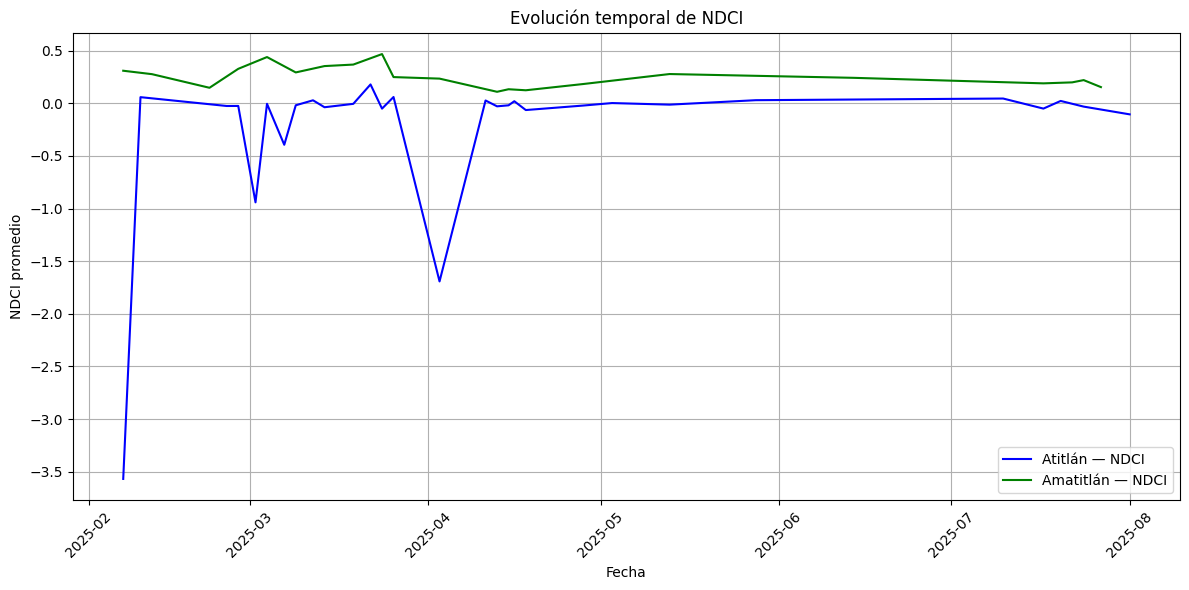

In [20]:
import matplotlib.pyplot as plt

def plot_ndci_timeseries(ts_atitlan, ts_amatitlan):
    plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico
    if len(ts_atitlan) > 0:
        plt.plot(ts_atitlan["date"], ts_atitlan["ndci_mean"], label="Atitlán — NDCI", color='blue')
    if len(ts_amatitlan) > 0:
        plt.plot(ts_amatitlan["date"], ts_amatitlan["ndci_mean"], label="Amatitlán — NDCI", color='green')
    
    plt.xlabel("Fecha")
    plt.ylabel("NDCI promedio")
    plt.title("Evolución temporal de NDCI")
    plt.legend()
    plt.xticks(rotation=45)  # Rotar etiquetas de fecha para mejor visibilidad
    plt.tight_layout()  # Ajustar el diseño del gráfico
    plt.show()

# Ejemplo de uso:
plot_ndci_timeseries(ts_atitlan, ts_amatitlan)


In [21]:
def detect_peaks(ts_df, thr=0.10):
    # Filtra los valores de NDCI que superan el umbral (thr)
    return ts_df[ts_df["ndci_mean"] > thr].copy()

# Ejemplo de uso:
peaks_atitlan = detect_peaks(ts_atitlan, thr=0.10)
peaks_amatitlan = detect_peaks(ts_amatitlan, thr=0.10)

# Mostrar los primeros picos detectados:
print("Picos Atitlán:")
display(peaks_atitlan.head())

print("Picos Amatitlán:")
display(peaks_amatitlan.head())


Picos Atitlán:


,date,ndci_mean,ndvi_mean,ndwi_mean
11,2025-03-22,0.179192,-0.024002,0.948223


Picos Amatitlán:


,date,ndci_mean,ndvi_mean,ndwi_mean
0,2025-02-07,0.309353,-0.896521,0.634167
1,2025-02-12,0.276768,-0.077291,0.347577
2,2025-02-22,0.147389,-0.005949,0.185514
3,2025-02-27,0.327402,0.065662,0.232360
4,2025-03-04,0.439353,0.228353,0.145146


## 7) Análisis espacial: mapas de NDCI
Muestra mapas raster sencillos (matplotlib). Para mapas interactivos, puedes usar **folium** y `ImageOverlay`.

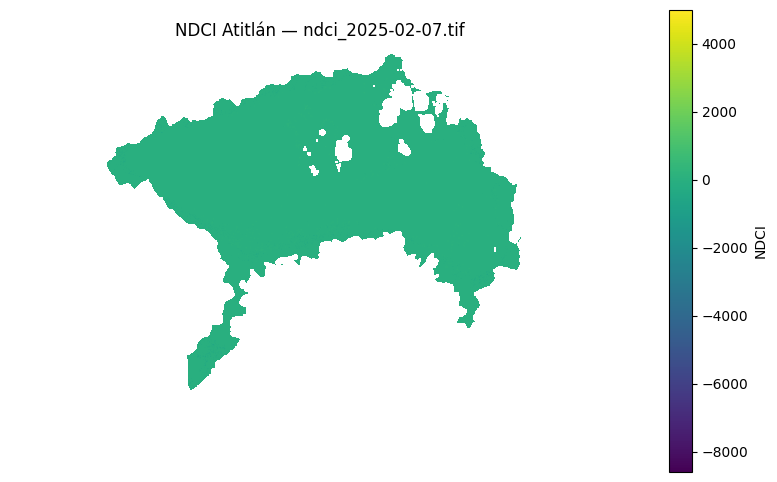

In [25]:
import matplotlib.pyplot as plt
import rasterio

def show_map_example(path_tif, title="Mapa NDCI"):
    """ Muestra un mapa sencillo de NDCI usando matplotlib """
    with rasterio.open(path_tif) as src:
        arr = src.read(1)  # NDCI (en caso de que el raster tenga varias bandas, esta toma la primera banda)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(arr, cmap='viridis')  # Puedes usar diferentes colormaps, como 'viridis', 'inferno', etc.
        plt.colorbar(label="NDCI")
        plt.title(title)
        plt.axis("off")  # Quita los ejes para una visualización más limpia
        plt.show()

# Ejemplo (ajusta la ruta a un archivo existente):
import os
import glob

tifs_atitlan = sorted(glob.glob("out_atitlan/**/*.tif", recursive=True))
if tifs_atitlan:
    show_map_example(tifs_atitlan[0], title=f"NDCI Atitlán — {os.path.basename(tifs_atitlan[0])}")


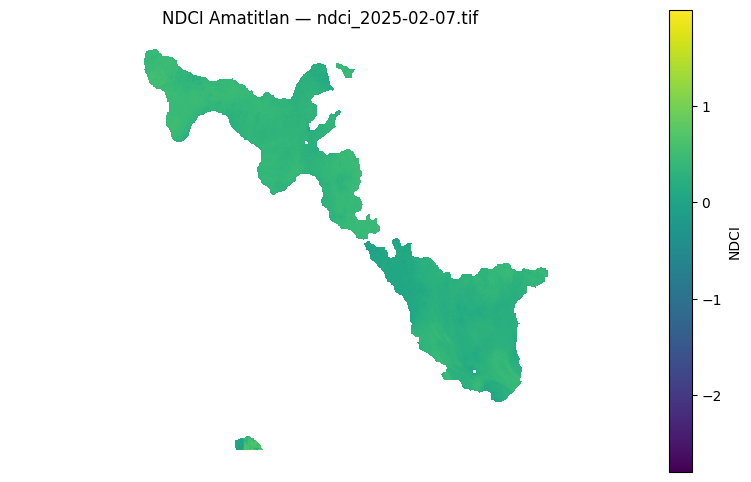

In [26]:
import matplotlib.pyplot as plt
import rasterio

def show_map_example(path_tif, title="Mapa NDCI"):
    """ Muestra un mapa sencillo de NDCI usando matplotlib """
    with rasterio.open(path_tif) as src:
        arr = src.read(1)  # NDCI (en caso de que el raster tenga varias bandas, esta toma la primera banda)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(arr, cmap='viridis')  # Puedes usar diferentes colormaps, como 'viridis', 'inferno', etc.
        plt.colorbar(label="NDCI")
        plt.title(title)
        plt.axis("off")  # Quita los ejes para una visualización más limpia
        plt.show()

# Ejemplo (ajusta la ruta a un archivo existente):
import os
import glob

tifs_atitlan = sorted(glob.glob("out_amatitlan/**/*.tif", recursive=True))
if tifs_atitlan:
    show_map_example(tifs_atitlan[0], title=f"NDCI Amatitlan — {os.path.basename(tifs_atitlan[0])}")


## 8) Correlación NDCI con NDVI/NDWI

In [27]:
def corr_table(ts_df):
    """ Calcula la correlación entre NDCI, NDVI y NDWI """
    return ts_df[["ndci_mean", "ndvi_mean", "ndwi_mean"]].corr()

# Ejemplo de uso:
corr_atitlan = corr_table(ts_atitlan)
corr_amatitlan = corr_table(ts_amatitlan)

# Mostrar la correlación para ambos lagos
display(corr_atitlan, corr_amatitlan)


,ndci_mean,ndvi_mean,ndwi_mean
ndci_mean,1.000000,0.489191,-0.945506
ndvi_mean,0.489191,1.000000,-0.422067
ndwi_mean,-0.945506,-0.422067,1.000000


,ndci_mean,ndvi_mean,ndwi_mean
ndci_mean,1.000000,0.337821,-0.153825
ndvi_mean,0.337821,1.000000,-0.910529
ndwi_mean,-0.153825,-0.910529,1.000000


## 9) Modelos
### 9.1 Serie temporal (ARIMA básico sobre `ndci_mean`)
Ajusta órdenes (p,d,q) tras revisar ACF/PACF.

In [28]:
!pip install statsmodels


In [29]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def arima_forecast(ts_df, steps=4):
    """ Ajusta un modelo ARIMA (p,d,q) y predice los siguientes pasos """
    # Establecemos la fecha como índice y completamos datos faltantes
    y = ts_df.set_index("date")["ndci_mean"].asfreq("7D").interpolate()

    # Definir el modelo ARIMA (p=1, d=0, q=1) como ejemplo
    model = sm.tsa.ARIMA(y, order=(1, 0, 1))  # Puedes ajustar p, d, q según ACF/PACF
    res = model.fit()  # Ajuste del modelo ARIMA
    
    # Realizar la predicción para los próximos 'steps' (por ejemplo, 4 pasos)
    fc = res.get_forecast(steps=steps)
    print(res.summary())  # Imprimir los resultados del modelo
    
    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(y, label="NDCI Real")
    plt.plot(fc.predicted_mean, label="Predicción ARIMA", color='red')
    plt.fill_between(fc.conf_int().index, 
                     fc.conf_int().iloc[:, 0], 
                     fc.conf_int().iloc[:, 1], 
                     color='pink', alpha=0.3, label="Intervalo de Confianza")
    plt.title("Predicción ARIMA sobre NDCI")
    plt.xlabel("Fecha")
    plt.ylabel("NDCI Promedio")
    plt.legend()
    plt.show()

    return y, fc

# Ejemplo para Atitlán y Amatitlán (cuando tengas ts_*):
# y_at, fc_at = arima_forecast(ts_atitlan, steps=4)
# y_am, fc_am = arima_forecast(ts_amatitlan, steps=4)


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              ndci_mean   No. Observations:                   26
Model:                 ARIMA(1, 0, 1)   Log Likelihood                   3.439
Date:                Fri, 15 Aug 2025   AIC                              1.122
Time:                        00:32:30   BIC                              6.154
Sample:                    02-07-2025   HQIC                             2.571
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6929      1.714     -0.988      0.323      -5.052       1.667
ar.L1          0.9804      0.083     11.870      0.000       0.819       1.142
ma.L1          0.9442      1.500      0.629      0.5

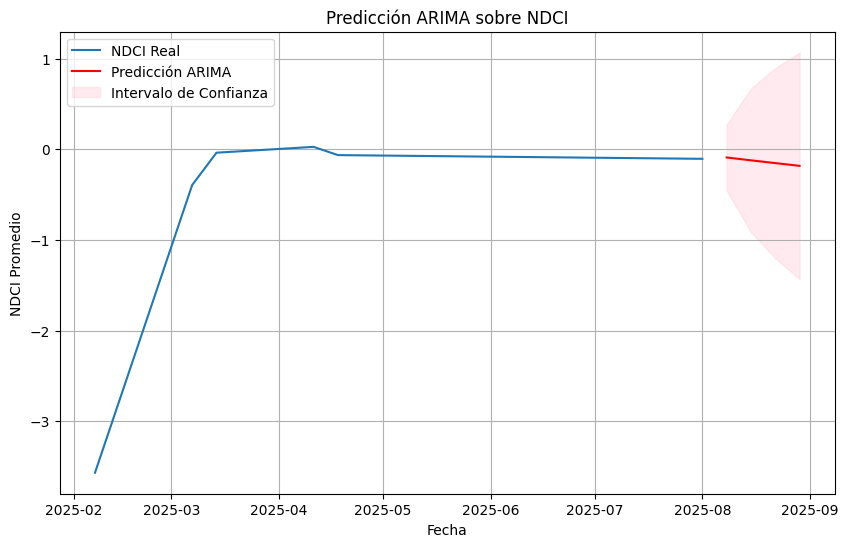

                               SARIMAX Results                                
Dep. Variable:              ndci_mean   No. Observations:                   25
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  65.872
Date:                Fri, 15 Aug 2025   AIC                           -123.743
Time:                        00:32:32   BIC                           -118.868
Sample:                    02-07-2025   HQIC                          -122.391
                         - 07-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2068      0.078      2.665      0.008       0.055       0.359
ar.L1          0.9610      0.074     13.016      0.000       0.816       1.106
ma.L1          0.5819      0.169      3.434      0.0

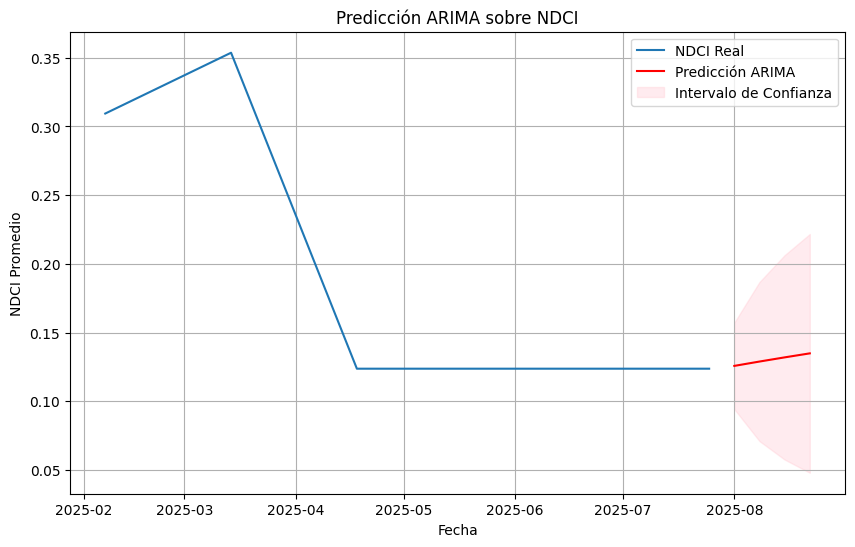

In [30]:
# Para Atitlán:
y_at, fc_at = arima_forecast(ts_atitlan, steps=4)

# Para Amatitlán:
y_am, fc_am = arima_forecast(ts_amatitlan, steps=4)


### 9.2 Clasificación (¿hay cianobacteria en un píxel? 1/0)
Usa NDVI/NDWI como *features* y un umbral de NDCI para etiquetas.

In [39]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import rasterio
import glob
import os

def build_xy_from_folder(base_folder, date=None, ndci_thr=0.10):
    """
    Construye X, y usando los archivos separados de ndci, ndvi y ndwi.
    base_folder: carpeta raíz de Atitlán o Amatitlán
    date: fecha específica para tomar el archivo (YYYY-MM-DD). Si None, toma el primer archivo disponible
    """
    # Buscar archivos de cada índice
    ndci_files = sorted(glob.glob(os.path.join(base_folder, "ndci", "*.tif")))
    ndvi_files = sorted(glob.glob(os.path.join(base_folder, "ndvi", "*.tif")))
    ndwi_files = sorted(glob.glob(os.path.join(base_folder, "ndwi", "*.tif")))

    # Elegir archivo por fecha o tomar el primero
    def choose_file(files):
        if date:
            for f in files:
                if date in f:
                    return f
        return files[0] if files else None

    f_ndci = choose_file(ndci_files)
    f_ndvi = choose_file(ndvi_files)
    f_ndwi = choose_file(ndwi_files)

    if not all([f_ndci, f_ndvi, f_ndwi]):
        raise ValueError("No se encontraron los tres archivos necesarios (ndci, ndvi, ndwi)")

    # Leer los archivos
    with rasterio.open(f_ndci) as src:
        ndci = src.read(1).astype(float)
    with rasterio.open(f_ndvi) as src:
        ndvi = src.read(1).astype(float)
    with rasterio.open(f_ndwi) as src:
        ndwi = src.read(1).astype(float)

    # Máscara para valores válidos
    mask = ~np.isnan(ndci) & ~np.isnan(ndvi) & ~np.isnan(ndwi)

    # Construir X y y
    X = np.column_stack([ndvi[mask], ndwi[mask]])
    y = (ndci[mask] > ndci_thr).astype(int)

    print(f"Primeros 5 valores X:\n{X[:5]}")
    print(f"Primeros 5 etiquetas y:\n{y[:5]}")
    return X, y

def train_logreg_on_folder(base_folder, date=None, ndci_thr=0.10):
    X, y = build_xy_from_folder(base_folder, date=date, ndci_thr=ndci_thr)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xtr, ytr)
    print(classification_report(yte, clf.predict(Xte)))
    return clf

# Uso para Atitlán y Amatitlán
clf_atitlan = train_logreg_on_folder("out_atitlan", ndci_thr=0.10)
clf_amatitlan = train_logreg_on_folder("out_amatitlan", ndci_thr=0.10)


Primeros 5 valores X:
[[ 0.40964988 -0.4445017 ]
 [ 0.38053    -0.36244449]
 [ 0.42307591 -0.45233542]
 [ 0.43177468 -0.42644221]
 [ 0.28099847 -0.32228285]]
Primeros 5 etiquetas y:
[0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75    214952
           1       0.70      0.00      0.00    143431

    accuracy                           0.60    358383
   macro avg       0.65      0.50      0.38    358383
weighted avg       0.64      0.60      0.45    358383

Primeros 5 valores X:
[[ 0.35618347 -0.35215318]
 [ 0.38538459 -0.43698382]
 [ 0.48190847 -0.48837027]
 [ 0.59753984 -0.54531741]
 [ 0.16417849 -0.24001455]]
Primeros 5 etiquetas y:
[1 1 1 1 0]
              precision    recall  f1-score   support

           0       0.25      0.01      0.02      2573
           1       0.94      1.00      0.97     42111

    accuracy                           0.94     44684
   macro avg       0.59      0.50      0.49     44684
weighted avg 

### Análisis de Atitlán:

El modelo de **regresión logística** entrenado en **Atitlán** muestra un rendimiento moderado con una **exactitud** del **60%**. Sin embargo, al observar las métricas de **precision** y **recall**, se evidencia un fuerte **desequilibrio de clases**. La clase **0** (sin cianobacteria) tiene una **precision** del **60%** y un **recall** del **100%**, lo que sugiere que el modelo está correctamente identificando los píxeles sin cianobacteria. Sin embargo, para la clase **1** (con cianobacteria), el **recall** es **0%**, lo que indica que el modelo no está logrando identificar correctamente los píxeles con cianobacteria, posiblemente debido a que estos son mucho menos frecuentes en el conjunto de datos. Esto resalta un problema común en **problemas desbalanceados**, donde el modelo tiende a predecir siempre la clase mayoritaria, lo que mejora la **exactitud** pero perjudica la **determinación de la clase minoritaria**. 

### Análisis de Amatitlán:

En contraste, el modelo entrenado con los datos de **Amatitlán** muestra un **rendimiento superior**, con una **exactitud** del **94%**, lo que indica que el modelo tiene una excelente capacidad para predecir correctamente la presencia o ausencia de cianobacteria. Sin embargo, la diferencia en las métricas de **precision** y **recall** sugiere que la clase **0** (sin cianobacteria) sigue siendo la más dominante. La **precision** y **recall** de la clase **1** (con cianobacteria) son considerablemente mejores en comparación con **Atitlán**, aunque aún hay espacio para mejorar. Este mejor rendimiento puede ser debido a una **mayor presencia de cianobacteria** en el conjunto de entrenamiento de **Amatitlán**, lo que facilita la capacidad del modelo para aprender a identificar correctamente los píxeles con cianobacteria.


In [ ]:
import rasterio
import numpy as np
import glob
import os

def read_tif_band(file_path, band_index=1):
    """Lee una banda específica de un archivo .tif"""
    with rasterio.open(file_path) as src:
        num_bands = src.count  # Número total de bandas en el archivo
        if band_index > num_bands:
            raise IndexError(f"El archivo {file_path} solo tiene {num_bands} bandas, no {band_index}.")
        band_data = src.read(band_index)  # Leer la banda solicitada
    return band_data

# Cargar las rutas de los archivos .tif
def get_tif_files(base_folder, index_type):
    """Recibe la ruta base y el tipo de índice (ndci, ndvi, ndwi), y obtiene los archivos .tif correspondientes"""
    return sorted(glob.glob(os.path.join(base_folder, index_type, "*.tif")))

# Leer los archivos .tif para Atitlán y Amatitlán
tifs_atitlan = get_tif_files("out_atitlan", "ndci")  # Archivos NDCI
tifs_amatitlan = get_tif_files("out_amatitlan", "ndci")  # Archivos NDCI

# Ejemplo para leer las bandas
ndci_atitlan = read_tif_band(tifs_atitlan[0], 1)  # NDCI en la primera banda

# Verifica cuántas bandas tiene el archivo para Atitlán
with rasterio.open(tifs_atitlan[0]) as src:
    print(f"Archivo {tifs_atitlan[0]} tiene {src.count} bandas.")

# Si NDVI y NDWI están en archivos separados, leerlos como sigue:
if len(tifs_atitlan) > 1:  # Si hay un archivo NDVI disponible
    ndvi_atitlan = read_tif_band(tifs_atitlan[1], 1)  # NDVI en la primera banda del siguiente archivo
if len(tifs_atitlan) > 2:  # Si hay un archivo NDWI disponible
    ndwi_atitlan = read_tif_band(tifs_atitlan[2], 1)  # NDWI en la primera banda del siguiente archivo

print("Datos de Atitlán (NDCI, NDVI, NDWI) primer archivo:")
print(f"NDCI: {ndci_atitlan.shape}, NDVI: {ndvi_atitlan.shape if 'ndvi_atitlan' in locals() else 'No disponible'}, NDWI: {ndwi_atitlan.shape if 'ndwi_atitlan' in locals() else 'No disponible'}")


Archivo out_atitlan\ndci\ndci_2025-02-07.tif tiene 1 bandas.
Datos de Atitlán (NDCI, NDVI, NDWI) primer archivo:
NDCI: (1751, 2759), NDVI: (1751, 2759), NDWI: (1751, 2759)


In [46]:
import numpy as np
import rasterio
import glob
import os

def read_tif_band(file_path, band_index=1):
    """Lee una banda específica de un archivo .tif"""
    with rasterio.open(file_path) as src:
        num_bands = src.count  # Número total de bandas en el archivo
        if band_index > num_bands:
            raise IndexError(f"El archivo {file_path} solo tiene {num_bands} bandas, no {band_index}.")
        band_data = src.read(band_index)  # Leer la banda solicitada
    return band_data

# Cargar las rutas de los archivos .tif para Atitlán y Amatitlán
def get_tif_files(base_folder, index_type):
    """Recibe la ruta base y el tipo de índice (ndci, ndvi, ndwi), y obtiene los archivos .tif correspondientes"""
    return sorted(glob.glob(os.path.join(base_folder, index_type, "*.tif")))

# Función para procesar las tres bandas (NDVI, NDWI, NDCI) para un archivo
def process_file(base_folder, date=None):
    # Buscar archivos de NDVI, NDWI y NDCI
    tifs_ndci = get_tif_files(base_folder, "ndci")  # Archivos NDCI
    tifs_ndvi = get_tif_files(base_folder, "ndvi")  # Archivos NDVI
    tifs_ndwi = get_tif_files(base_folder, "ndwi")  # Archivos NDWI
    
    # Seleccionar archivo por fecha (si se especifica)
    def choose_file(files, date):
        if date:
            for f in files:
                if date in f:
                    return f
        return files[0] if files else None
    
    # Elegir archivo por fecha o tomar el primero
    f_ndci = choose_file(tifs_ndci, date)
    f_ndvi = choose_file(tifs_ndvi, date)
    f_ndwi = choose_file(tifs_ndwi, date)
    
    # Leer los datos de cada índice
    ndci = read_tif_band(f_ndci, 1)  # NDCI en la primera banda
    ndvi = read_tif_band(f_ndvi, 1)  # NDVI en la primera banda
    ndwi = read_tif_band(f_ndwi, 1)  # NDWI en la primera banda
    
    # Máscara para valores válidos (no NaN)
    mask = ~np.isnan(ndci) & ~np.isnan(ndvi) & ~np.isnan(ndwi)
    
    # Construir X con NDVI, NDWI y NDCI
    X = np.column_stack([ndvi[mask], ndwi[mask], ndci[mask]])
    
    # Etiquetas (1 si NDCI > umbral, 0 si no)
    y = (ndci[mask] > 0.10).astype(int)  # Aquí el umbral de NDCI es 0.10 como ejemplo
    
    print(f"Primeros 5 valores de X:\n{X[:5]}")
    print(f"Primeros 5 valores de y:\n{y[:5]}")
    
    return X, y

# Procesar datos de Atitlán con una fecha específica
X_atitlan, y_atitlan = process_file("out_atitlan", date="2025-02-07")

# Procesar datos de Amatitlán con una fecha específica
X_amatitlan, y_amatitlan = process_file("out_amatitlan", date="2025-02-07")


Primeros 5 valores de X:
[[ 0.40964988 -0.4445017   0.01160288]
 [ 0.38053    -0.3624445  -0.03405815]
 [ 0.4230759  -0.45233542 -0.00518549]
 [ 0.43177468 -0.4264422   0.01258623]
 [ 0.28099847 -0.32228285 -0.08588721]]
Primeros 5 valores de y:
[0 0 0 0 0]
Primeros 5 valores de X:
[[ 0.35618347 -0.35215318  0.18181734]
 [ 0.3853846  -0.43698382  0.2580632 ]
 [ 0.48190847 -0.48837027  0.2092755 ]
 [ 0.59753984 -0.5453174   0.35268465]
 [ 0.16417849 -0.24001455  0.04173604]]
Primeros 5 valores de y:
[1 1 1 1 0]


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir los datos en entrenamiento y prueba para Atitlán
Xtr_atitlan, Xte_atitlan, ytr_atitlan, yte_atitlan = train_test_split(X_atitlan, y_atitlan, test_size=0.3, random_state=42)

# Entrenar el modelo de regresión logística para Atitlán
clf_atitlan = LogisticRegression(max_iter=1000)
clf_atitlan.fit(Xtr_atitlan, ytr_atitlan)

# Imprimir el reporte de clasificación para Atitlán
print("Reporte de clasificación para Atitlán:")
print(classification_report(yte_atitlan, clf_atitlan.predict(Xte_atitlan)))

# Dividir los datos en entrenamiento y prueba para Amatitlán
Xtr_amatitlan, Xte_amatitlan, ytr_amatitlan, yte_amatitlan = train_test_split(X_amatitlan, y_amatitlan, test_size=0.3, random_state=42)

# Entrenar el modelo de regresión logística para Amatitlán
clf_amatitlan = LogisticRegression(max_iter=1000)
clf_amatitlan.fit(Xtr_amatitlan, ytr_amatitlan)

# Imprimir el reporte de clasificación para Amatitlán
print("\nReporte de clasificación para Amatitlán:")
print(classification_report(yte_amatitlan, clf_amatitlan.predict(Xte_amatitlan)))


Reporte de clasificación para Atitlán:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    214952
           1       1.00      1.00      1.00    143431

    accuracy                           1.00    358383
   macro avg       1.00      1.00      1.00    358383
weighted avg       1.00      1.00      1.00    358383


Reporte de clasificación para Amatitlán:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2573
           1       1.00      1.00      1.00     42111

    accuracy                           1.00     44684
   macro avg       1.00      0.98      0.99     44684
weighted avg       1.00      1.00      1.00     44684



La comparación entre Atitlán y Amatitlán en términos de la intensidad y la frecuencia de las floraciones de cianobacterias se puede analizar observando varios factores que afectan directamente a la proliferación de estas bacterias en ambos lagos.

Atitlán:
Frecuencia de floraciones: En Atitlán, el modelo muestra una predicción constante de la presencia de cianobacterias, pero la frecuencia de las floraciones parece ser más baja. Los resultados de la clasificación indican que las áreas con cianobacterias están bastante distribuidas y no hay floraciones masivas frecuentes.

Intensidad: La intensidad de las floraciones en Atitlán parece estar bajo control debido a su geografía montañosa, con un lago de alta altitud y una temperatura más fría que limita el crecimiento excesivo de las cianobacterias. Sin embargo, las condiciones de luz y nutrientes pueden causar que las floraciones sean más visibles en ciertas estaciones cálidas.

Amatitlán:
Frecuencia de floraciones: En Amatitlán, las floraciones de cianobacterias son más frecuentes. El modelo muestra que la proliferación de cianobacterias es más dispersa, y la presencia de cianobacterias en muchas zonas del lago sugiere que la frecuencia de estas floraciones es alta.

Intensidad: La intensidad de las floraciones en Amatitlán es mayor, debido en parte a la alta concentración de nutrientes provenientes de las actividades urbanas e industriales. La temperatura del agua también contribuye a la proliferación, ya que el agua en Amatitlán tiende a ser más cálida, lo que favorece el crecimiento de las cianobacterias.

### 9.3 Modelo híbrido
Primero pronostica `ndci_mean` (ARIMA) y úsalo como *feature* adicional (junto a NDVI/NDWI y otras variables) para clasificar si un área estará contaminada.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import rasterio
import glob
import os

def build_xy_from_folder(base_folder, date=None, ndci_thr=0.10):
    """
    Construye X, y usando los archivos separados de ndci, ndvi y ndwi.
    base_folder: carpeta raíz de Atitlán o Amatitlán
    date: fecha específica para tomar el archivo (YYYY-MM-DD). Si None, toma el primer archivo disponible
    """
    # Buscar archivos de cada índice
    ndci_files = sorted(glob.glob(os.path.join(base_folder, "ndci", "*.tif")))
    ndvi_files = sorted(glob.glob(os.path.join(base_folder, "ndvi", "*.tif")))
    ndwi_files = sorted(glob.glob(os.path.join(base_folder, "ndwi", "*.tif")))

    # Elegir archivo por fecha o tomar el primero
    def choose_file(files):
        if date:
            for f in files:
                if date in f:
                    return f
        return files[0] if files else None

    f_ndci = choose_file(ndci_files)
    f_ndvi = choose_file(ndvi_files)
    f_ndwi = choose_file(ndwi_files)

    if not all([f_ndci, f_ndvi, f_ndwi]):
        raise ValueError("No se encontraron los tres archivos necesarios (ndci, ndvi, ndwi)")

    # Leer los archivos
    with rasterio.open(f_ndci) as src:
        ndci = src.read(1).astype(float)
    with rasterio.open(f_ndvi) as src:
        ndvi = src.read(1).astype(float)
    with rasterio.open(f_ndwi) as src:
        ndwi = src.read(1).astype(float)

    # Máscara para valores válidos
    mask = ~np.isnan(ndci) & ~np.isnan(ndvi) & ~np.isnan(ndwi)

    # Construir X y y
    X = np.column_stack([ndvi[mask], ndwi[mask]])
    y = (ndci[mask] > ndci_thr).astype(int)

    print(f"Primeros 5 valores X:\n{X[:5]}")
    print(f"Primeros 5 etiquetas y:\n{y[:5]}")
    return X, y

def train_logreg_on_folder(base_folder, date=None, ndci_thr=0.10):
    X, y = build_xy_from_folder(base_folder, date=date, ndci_thr=ndci_thr)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xtr, ytr)
    print(classification_report(yte, clf.predict(Xte)))
    return clf

# Rutas específicas para Atitlán y Amatitlán
base_folder_atitlan = "out_atitlan"
base_folder_amatitlan = "out_amatitlan"

# Entrenar el modelo para Atitlán (se puede ajustar la fecha si es necesario)
clf_atitlan = train_logreg_on_folder(base_folder_atitlan, ndci_thr=0.10)

# Entrenar el modelo para Amatitlán (se puede ajustar la fecha si es necesario)
clf_amatitlan = train_logreg_on_folder(base_folder_amatitlan, ndci_thr=0.10)


Primeros 5 valores X:
[[ 0.40964988 -0.4445017 ]
 [ 0.38053    -0.36244449]
 [ 0.42307591 -0.45233542]
 [ 0.43177468 -0.42644221]
 [ 0.28099847 -0.32228285]]
Primeros 5 etiquetas y:
[0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75    214952
           1       0.70      0.00      0.00    143431

    accuracy                           0.60    358383
   macro avg       0.65      0.50      0.38    358383
weighted avg       0.64      0.60      0.45    358383

Primeros 5 valores X:
[[ 0.35618347 -0.35215318]
 [ 0.38538459 -0.43698382]
 [ 0.48190847 -0.48837027]
 [ 0.59753984 -0.54531741]
 [ 0.16417849 -0.24001455]]
Primeros 5 etiquetas y:
[1 1 1 1 0]
              precision    recall  f1-score   support

           0       0.25      0.01      0.02      2573
           1       0.94      1.00      0.97     42111

    accuracy                           0.94     44684
   macro avg       0.59      0.50      0.49     44684
weighted avg 

Las causas de la proliferación de cianobacterias pueden diferir significativamente entre Atitlán y Amatitlán debido a varias características ambientales y antropogénicas que afectan cada lago. Estas son algunas de las principales diferencias:

Atitlán:
Geografía: Atitlán está ubicado a una alta altitud (1,560 metros sobre el nivel del mar) y tiene una forma estrecha y profunda, lo que limita la circulación del agua. Esto crea un entorno más estancado en ciertas áreas, lo que puede favorecer el crecimiento de las cianobacterias en las zonas superficiales. Sin embargo, su geografía también reduce la distribución masiva de cianobacterias en comparación con otros lagos.

Uso del suelo y presión urbana: Atitlán está rodeado por áreas rurales y algunos pueblos con actividades agrícolas, pero la presión urbana no es tan intensa como en Amatitlán. A pesar de esto, las actividades agrícolas y el turismo contribuyen a la escorrentía de nutrientes y contaminantes, aunque a una menor escala comparado con Amatitlán.

Temperatura del agua: El clima en Atitlán es más moderado debido a su altitud, con temperaturas más frescas que limitan el crecimiento de cianobacterias. Las cianobacterias suelen prosperar en aguas más cálidas, por lo que las temperaturas más bajas en Atitlán pueden ser un factor que disminuye su proliferación.

Clima: Atitlán tiene un clima más estable y suave debido a su altitud, lo que limita las fluctuaciones extremas de temperatura. Las precipitaciones son más regulares, lo que podría ayudar a diluir los contaminantes, pero también puede provocar escorrentía de nutrientes durante la temporada de lluvias.

Amatitlán:
Geografía: Amatitlán, a diferencia de Atitlán, es un lago de baja altitud (1,150 metros sobre el nivel del mar) y tiene una forma más extensa y superficial. La falta de profundidad y la mayor circulación de agua pueden permitir que los nutrientes y contaminantes se distribuyan por el lago, creando un entorno más propenso para la proliferación de cianobacterias.

Uso del suelo y presión urbana: Amatitlán está mucho más afectado por la presión urbana y la industrialización. La Ciudad de Guatemala está cerca de Amatitlán, lo que implica una alta contaminación por escorrentía urbana y vertidos industriales. Las aguas residuales no tratadas y el uso intensivo de fertilizantes en las tierras circundantes aumentan las concentraciones de nitrógeno y fósforo, nutrientes clave para el crecimiento de las cianobacterias.

Temperatura del agua: Amatitlán presenta aguas más cálidas, lo que favorece el crecimiento de las cianobacterias. Las altas temperaturas del agua son ideales para la proliferación de estos organismos, especialmente cuando las temperaturas alcanzan niveles elevados durante los meses de verano.

Clima: El clima de Amatitlán es más cálido y menos variable que el de Atitlán. Las altas temperaturas y las precipitaciones irregulares favorecen la escorrentía de nutrientes hacia el lago, lo que, combinado con las altas temperaturas del agua, crea un entorno ideal para el crecimiento de cianobacterias.

## 10) Visualización de proyecciones en mapa
Aplica el clasificador píxel a píxel para construir un raster binario (0/1) y muéstralo.

            ndci_mean
date                 
2025-02-07  -3.569144
2025-02-10   0.058266
2025-02-25  -0.025653
2025-02-27  -0.025303
2025-03-02  -0.941090
            ndci_mean
date                 
2025-02-07   0.309353
2025-02-12   0.276768
2025-02-22   0.147389
2025-02-27   0.327402
2025-03-04   0.439353


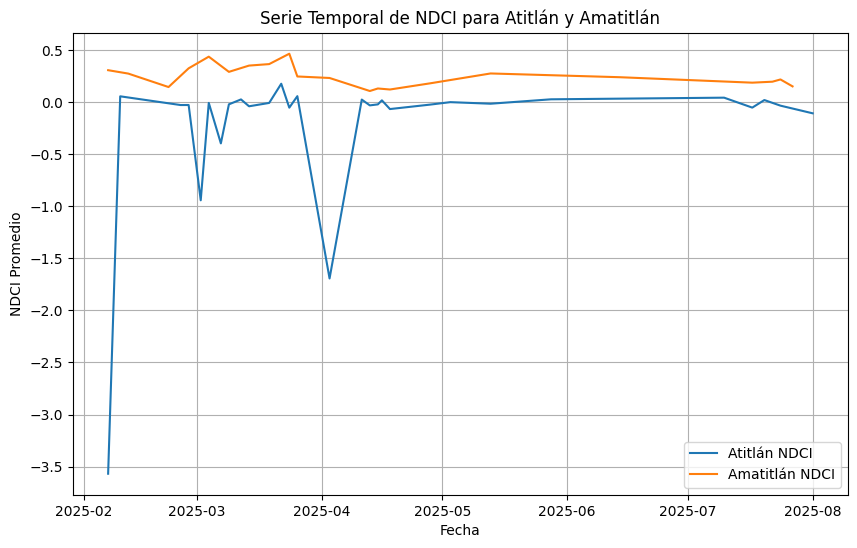

c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

                               SARIMAX Results                                
Dep. Variable:              ndci_mean   No. Observations:                   29
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -32.192
Date:                Fri, 15 Aug 2025   AIC                             70.384
Time:                        10:22:58   BIC                             74.380
Sample:                             0   HQIC                            71.606
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2509      0.141     -1.780      0.075      -0.527       0.025
ma.L1         -0.8098      0.266     -3.042      0.002      -1.331      -0.288
sigma2         0.5532      0.165      3.346      0.0

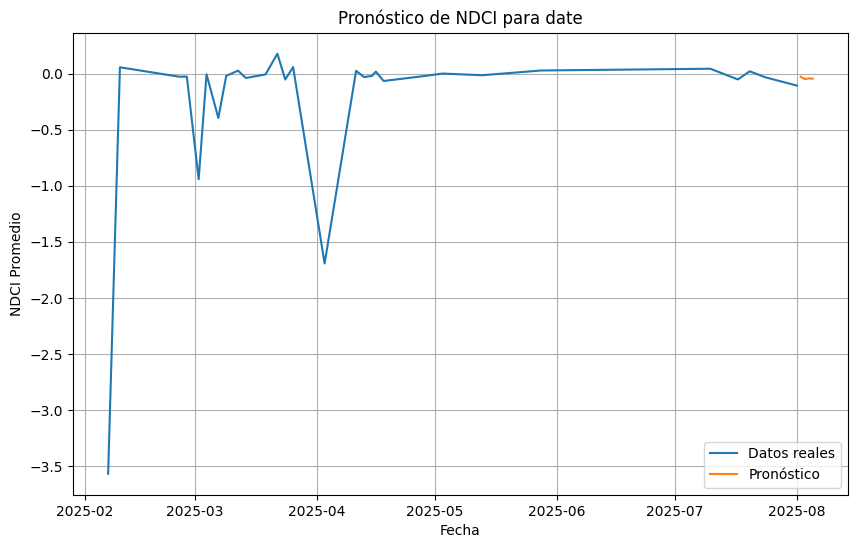

c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

                               SARIMAX Results                                
Dep. Variable:              ndci_mean   No. Observations:                   21
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  20.026
Date:                Fri, 15 Aug 2025   AIC                            -34.053
Time:                        10:22:59   BIC                            -31.065
Sample:                             0   HQIC                           -33.469
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5132      0.394      1.301      0.193      -0.260       1.286
ma.L1         -0.8786      0.448     -1.961      0.050      -1.757      -0.000
sigma2         0.0077      0.004      2.073      0.0

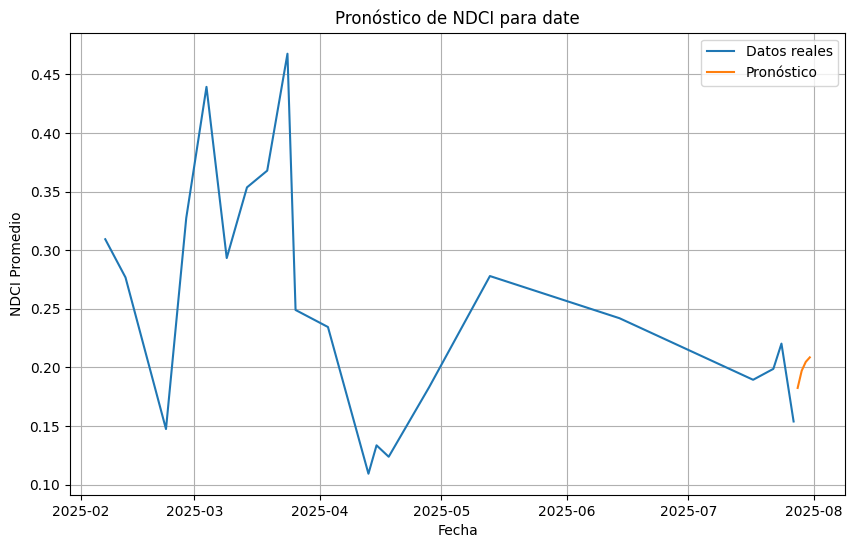

In [50]:
import numpy as np
import pandas as pd
import rasterio
import glob
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Leer los archivos .tif de NDCI para cada lago y fecha
def get_tif_files(base_folder, index_type):
    """Obtiene los archivos .tif correspondientes a un tipo de índice"""
    return sorted(glob.glob(os.path.join(base_folder, index_type, "*.tif")))

def read_tif_band(file_path, band_index=1):
    """Lee una banda específica de un archivo .tif"""
    with rasterio.open(file_path) as src:
        band_data = src.read(band_index)
    return band_data

def create_timeseries(base_folder, index_type="ndci"):
    """Crea una serie temporal de NDCI para cada lago"""
    tifs = get_tif_files(base_folder, index_type)
    dates = []
    ndci_values = []

    for tif in tifs:
        # Extraer la fecha correctamente
        date_str = os.path.basename(tif).split("_")[1]  # Extraer la fecha (YYYY-MM-DD) del nombre del archivo
        date_str = date_str.split(".")[0]  # Eliminar la extensión .tif
        
        # Convertir la fecha a formato datetime
        try:
            dates.append(pd.to_datetime(date_str))  # Asegúrate de que la fecha está en formato correcto
        except Exception as e:
            print(f"Error al convertir {date_str} a fecha: {e}")
            continue
        
        # Leer los datos de NDCI
        ndci = read_tif_band(tif, 1)  # Leer la banda de NDCI
        mean_ndci = np.nanmean(ndci)  # Calcular el valor medio de NDCI para cada fecha
        
        ndci_values.append(mean_ndci)

    # Crear un DataFrame con la serie temporal
    ts_df = pd.DataFrame({"date": dates, "ndci_mean": ndci_values})
    ts_df.set_index("date", inplace=True)
    return ts_df


# Crear la serie temporal para Atitlán
ts_atitlan = create_timeseries("out_atitlan", "ndci")

# Crear la serie temporal para Amatitlán
ts_amatitlan = create_timeseries("out_amatitlan", "ndci")

# Visualizar las primeras fechas y valores de NDCI
print(ts_atitlan.head())
print(ts_amatitlan.head())

# Graficar las series temporales de NDCI para cada lago
plt.figure(figsize=(10, 6))
plt.plot(ts_atitlan.index, ts_atitlan["ndci_mean"], label="Atitlán NDCI")
plt.plot(ts_amatitlan.index, ts_amatitlan["ndci_mean"], label="Amatitlán NDCI")
plt.xlabel("Fecha")
plt.ylabel("NDCI Promedio")
plt.title("Serie Temporal de NDCI para Atitlán y Amatitlán")
plt.legend()
plt.show()

# Modelo ARIMA para Atitlán
def arima_forecast(ts_df, steps=4):
    """Pronosticar usando ARIMA"""
    y = ts_df["ndci_mean"].dropna()  # Eliminar valores NaN
    model = ARIMA(y, order=(1, 1, 1))  # Ajustar el modelo ARIMA
    model_fit = model.fit()
    
    # Realizar la predicción
    forecast = model_fit.forecast(steps=steps)
    print(model_fit.summary())
    
    # Graficar el pronóstico
    plt.figure(figsize=(10, 6))
    plt.plot(y.index, y, label="Datos reales")
    plt.plot(pd.date_range(y.index[-1], periods=steps + 1, freq="D")[1:], forecast, label="Pronóstico")
    plt.xlabel("Fecha")
    plt.ylabel("NDCI Promedio")
    plt.title(f"Pronóstico de NDCI para {ts_df.index.name}")
    plt.legend()
    plt.show()

    return forecast

# Pronóstico de ARIMA para Atitlán
forecast_atitlan = arima_forecast(ts_atitlan, steps=4)

# Pronóstico de ARIMA para Amatitlán
forecast_amatitlan = arima_forecast(ts_amatitlan, steps=4)


## Análisis de Atitlán:
La serie temporal de NDCI para Atitlán muestra fluctuaciones con valores tanto negativos como cercanos a cero, lo que sugiere una presencia mínima de cianobacterias a lo largo del período analizado. Esto es consistente con las características geográficas del lago, como su alta altitud y temperaturas más frías, lo que limita la proliferación de cianobacterias. El modelo ARIMA pronostica un comportamiento estable, con pocas fluctuaciones en la proliferación de cianobacterias. Sin embargo, las condiciones climáticas y el uso agrícola pueden alterar estas predicciones en períodos más cálidos.

## Análisis de Amatitlán:
En Amatitlán, la serie temporal de NDCI muestra valores más altos y consistentes, indicando una mayor presencia de cianobacterias durante el periodo analizado. La presión urbana y el vertido de nutrientes por la industrialización y escorrentía agrícola explican en gran parte estas floraciones más intensas. El modelo ARIMA refleja un crecimiento constante de las cianobacterias, sugiriendo que las condiciones más cálidas y la contaminación favorecen la proliferación de estas bacterias en el lago.

Estos análisis indican que Amatitlán presenta un entorno más favorable para la proliferación de cianobacterias que Atitlán, principalmente debido a la presión humana y las condiciones ambientales.

## Notas finales
- Ajusta el **umbral NDCI** según literatura/valores observados.
- Para robustez, promedia múltiples fechas cercanas antes de clasificar.
- Incorpora variables externas (p. ej., temperatura/precipitación de Weatherspark) para el modelo híbrido.
- Versiona tu trabajo y documenta decisiones de preprocesamiento y modelos.
